In [73]:
import numpy as np
import jax.numpy as jnp
import jax

import matplotlib.pyplot as plt
from rikabplotlib.plot_utils import newplot


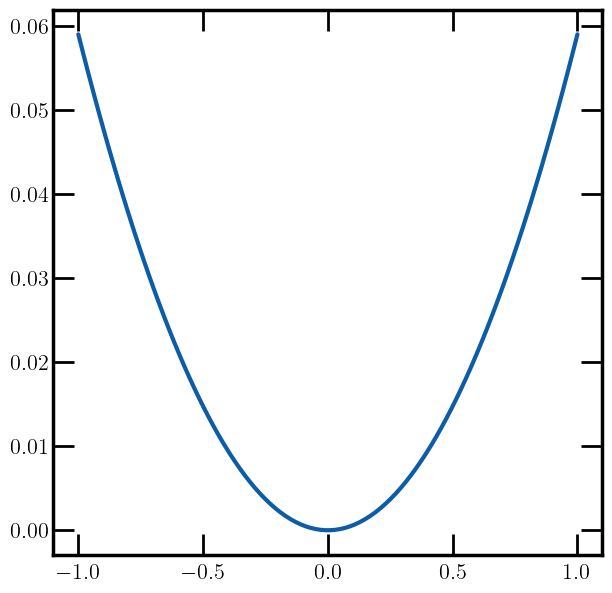

In [74]:
# M = 2 # Order of the polynomial in t
# N = 2 # Order of the polynomial in alpha

def polynomial_f(t, alpha, params):

    # MxN polynomial in t and alpha
    M, N = params.shape

    # Compute the polynomial
    poly = params * jnp.power(t, (1 + jnp.arange(M)[:, None])) * jnp.power(alpha, (1 + jnp.arange(N)[None, :])) 

    # Use the gamma function to compute the factorial
    factorials = jax.scipy.special.gamma(jnp.arange(M) + 2)[:, None] * jax.scipy.special.gamma(jnp.arange(N) + 2)[None, :]
    poly = poly / factorials

    return jnp.sum(poly, axis=(0, 1))



params = jnp.array([[0.0,0.0], [1.0,0.0]])

# plot the polynomial
t = jnp.linspace(-1, 1, 100)
alpha = jnp.ones(100) * 0.118

# Evaluate the polynomial
vectorized_polynomial_f = jax.vmap(polynomial_f, in_axes=(0, 0, None))
f = vectorized_polynomial_f(t, alpha, params)

fig, ax = newplot("full")
ax.plot(t, f)
plt.show()


# Take t gradient
polynomial_f_t = (jax.grad(polynomial_f, argnums=0))



[ 0.0000000e+00  7.2864647e+01  6.9559738e+01 ...  2.3610994e-05
  1.1803725e-05 -0.0000000e+00]


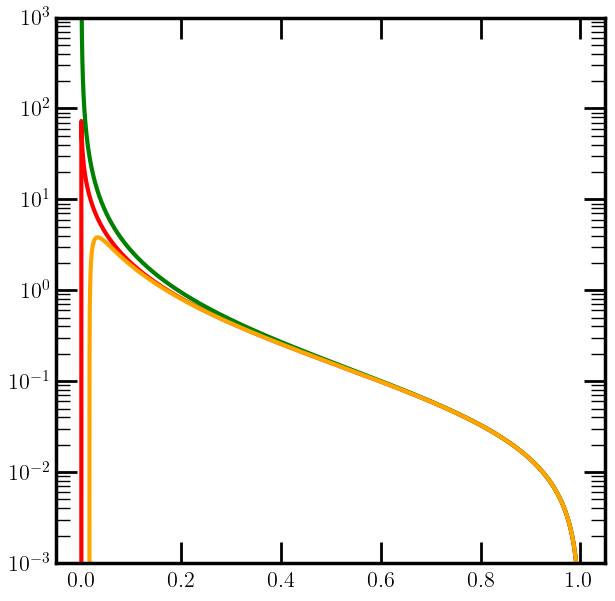

In [75]:
def construct_cdf(function):

    def cdf(x, alpha, params):
        return jnp.nan_to_num(jnp.exp(-function(-jnp.log(x), alpha, params)))
    return cdf



def construct_pdf(function):

    cdf = construct_cdf(function)
    derivative = jax.grad(cdf, argnums=0)

    def pdf(x, alpha, params):
        return jnp.nan_to_num(derivative(x, alpha, params) )


    return pdf



def taylor_expand_in_alpha(function, order):

    ps = [function,]
    if order > 0:
        for i in range(order):
            ps.append(jax.grad(ps[-1], argnums=1))

    def taylor_expansion(x, alpha, params):
        near_zero = 1e-16
        terms = jnp.array([p(x, near_zero, params) for p in ps])
        factorials = jax.scipy.special.gamma(jnp.arange(len(terms)) + 1)
        return jnp.sum(terms / factorials * jnp.power(alpha, jnp.arange(len(terms))))
    
    return taylor_expansion


    



pdf = construct_pdf(polynomial_f)
cdf = construct_cdf(polynomial_f)

taylor0 = taylor_expand_in_alpha(pdf, 0)
taylor1 = taylor_expand_in_alpha(pdf, 1)
taylor2 = taylor_expand_in_alpha(pdf, 2)



x = jnp.linspace(0.0, 1, 10000)
alpha = jnp.ones(10000) * 0.118




pdf = jax.vmap(pdf, in_axes=(0, 0, None))
cdf = jax.vmap(cdf, in_axes=(0, 0, None))
taylor0 = jax.vmap(taylor0, in_axes=(0, 0, None))
taylor1 = jax.vmap(taylor1, in_axes=(0, 0, None))
taylor2 = jax.vmap(taylor2, in_axes=(0, 0, None))


pdf_x = pdf(x, alpha, params)
cdf_x = cdf(x, alpha, params)
taylor0_x = taylor0(x, alpha, params)
taylor1_x = taylor1(x, alpha, params)
taylor2_x = taylor2(x, alpha, params)

# test2_x = test2(x)

print(pdf_x)

fig, ax = newplot("full")
ax.plot(x, pdf_x, color = "red", )
# ax.plot(x, cdf_x)
ax.plot(x, taylor0_x, color = "blue")
ax.plot(x, taylor1_x, color = "green")
ax.plot(x, taylor2_x, color = "orange")

ax.set_ylim(1e-3, 1e3)
ax.set_yscale("log")
plt.show()





In [76]:
# Get gradient of the pdf with respect to parameters
unvmapped_pdf = construct_pdf(polynomial_f)
pdf_grad = jax.grad(unvmapped_pdf, argnums=2)

pdf_grad_x = pdf_grad(1.0, 1.0, params)
print(pdf_grad_x)

[[1.         0.49999988]
 [0.         0.        ]]


In [77]:



def loss(params, p, q, xs, alphas):

    ps = p(xs, alphas)
    qs = q(xs, alphas, params)

    log_p = jnp.log(ps)
    log_q = jnp.log(qs)

    return jnp.mean(jnp.nan_to_num(jnp.power(log_p - log_q, 2)))


loss_grad = jax.grad(loss, argnums=0)


def higher_order_loss(params, q, taylor_q, xs, alphas):

    qs = q(xs, alphas, params)
    taylor_qs = taylor_q(xs, alphas, params)

    log_q = jnp.log(qs)
    log_taylor_q = jnp.log(taylor_qs)

    return jnp.mean(jnp.nan_to_num(jnp.power(log_q - log_taylor_q, 2)))

loss_higher_order_grad = jax.grad(higher_order_loss, argnums=0)

def project_params(params):
    return jnp.maximum(params, 0.0)


In [78]:
def p(x, alpha):
    return alpha * jnp.log(1/x) / x

In [79]:
import optax
from tqdm import tqdm

def train(order = 1, M = 3, N = 3, params = None, epochs = 1000, gamma_schedule = None, compile = True):

    batch_size = 2048
    learning_rate = 0.01
    losses = []
    if gamma_schedule is None:
        gamma_schedule = jnp.ones((epochs,3))

    if params is None:
        seed = jax.random.PRNGKey(0000)
        params = jax.random.uniform(seed, shape=(M,N))


    pdf = construct_pdf(polynomial_f)
    taylor_q = taylor_expand_in_alpha(pdf, order)
    q = pdf

    # vmap everything
    vmapped_p = jax.vmap(p, in_axes=(0, 0))
    vmapped_q = jax.vmap(q, in_axes=(0, 0, None))
    vmapped_taylor_q = jax.vmap(taylor_q, in_axes=(0, 0, None))
    vmapped_loss = loss
    vmapped_loss_grad = loss_grad

    vmapped_higher_order_loss = higher_order_loss
    vmapped_higher_order_loss_grad = loss_higher_order_grad
    # vmapped_loss = jax.vmap(loss, in_axes=(None, None, None, 0, 0))
    # vmapped_loss_grad = jax.vmap(loss_grad, in_axes=(None, None, None, 0, 0))

    # Compile everything
    if compile:
        vmapped_p = jax.jit(vmapped_p)
        vmapped_q = jax.jit(vmapped_q)
        vmapped_taylor_q = jax.jit(vmapped_taylor_q)
        vmapped_loss = jax.jit(loss, static_argnums=(1, 2))
        vmapped_loss_grad = jax.jit(loss_grad, static_argnums=(1, 2))

        vmapped_higher_order_loss = jax.jit(higher_order_loss, static_argnums=(1, 2))
        vmapped_higher_order_loss_grad = jax.jit(loss_higher_order_grad, static_argnums=(1, 2))

    # Optimizer
    optimizer = optax.adam(learning_rate)
    opt_state = optimizer.init(params)

    epoch_tqdm = tqdm(range(epochs))
    for i in epoch_tqdm:

        seed = jax.random.PRNGKey(i)

        # Randomly sample xs between 0 and 1
        xs = jax.random.uniform(seed, shape=(batch_size,))
        
        # if any of the xs are zero, re-roll
        while jnp.any(xs == 0):
            new_seed = jax.random.split(seed)[0]
            xs = jax.random.uniform(new_seed, shape=(batch_size,))
            seed = new_seed

        # Exponentially sample alphas
        # alphas = jax.random.exponential(seed, shape=(batch_size,)) 
        alphas = jax.random.uniform(seed, shape=(batch_size,)) 
        
        # Compute the loss and the gradient
        loss_q = vmapped_loss(params, vmapped_p, vmapped_q, xs, alphas)
        gradient_q = vmapped_loss_grad(params, vmapped_p, vmapped_q, xs, alphas)

        loss_taylor_q = vmapped_loss(params, vmapped_p, vmapped_taylor_q, xs, alphas)
        gradient_taylor_q = vmapped_loss_grad(params, vmapped_p, vmapped_taylor_q, xs, alphas)

        loss_higher_order = vmapped_higher_order_loss(params, vmapped_q, vmapped_taylor_q, xs, alphas)
        gradient_higher_order = vmapped_higher_order_loss_grad(params, vmapped_q, vmapped_taylor_q, xs, alphas)

        gamma = gamma_schedule[i]
        l = gamma[0] * loss_q + gamma[1] * loss_taylor_q + gamma[2] * loss_higher_order
        g = gamma[0] * gradient_q + gamma[1]*gradient_taylor_q + gamma[2] * gradient_higher_order

        # Update the parameters
        updates, opt_state = optimizer.update(g, opt_state)
    
        # Apply updates to get new params
        params = optax.apply_updates(params, updates)
        params = project_params(params)

        epoch_tqdm.set_description(f"Loss = {l}, Taylor loss = {loss_taylor_q}, Difference Loss = {loss_q}")
        losses.append((loss_q, loss_taylor_q, loss_higher_order))


    return params, np.array(losses)




In [80]:
# Pre-train for 1250 epochs. Then train on the derivatives only with the usual 10% difference term
epochs = 10000
gamma_schedule = np.zeros((epochs, 3))
gamma_schedule[:epochs // 2, 0] = 1.0

gamma_schedule[epochs // 2:, 0] = 0.000001
gamma_schedule[epochs // 2:, 1] = 0.999998
gamma_schedule[epochs // 2:, 2] = 0.000001


params, losses = train(1, M = 10, N = 10, epochs = epochs, gamma_schedule= gamma_schedule)

Loss = 1.1324057425099454e-07, Taylor loss = 8.182222260844085e-12, Difference Loss = 0.0566161572933197: 100%|██████████| 10000/10000 [03:36<00:00, 46.25it/s]  


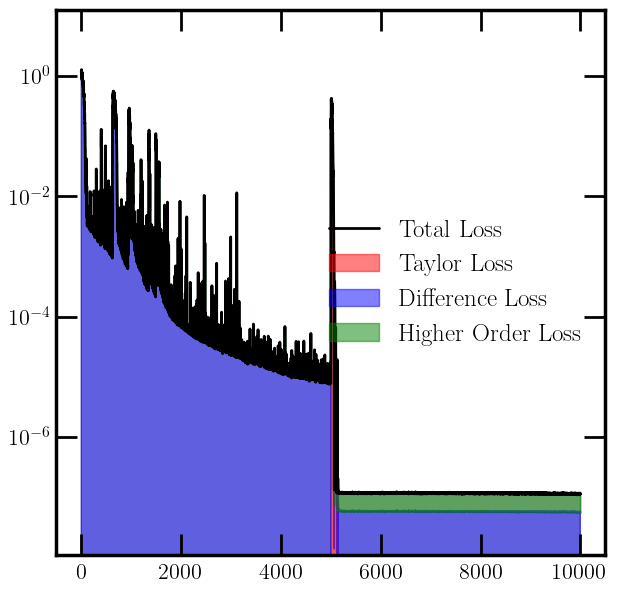

In [81]:
fig, ax = newplot("full")
losses = np.array(losses)
loss_q, loss_taylor, loss_higher_order = losses[:,0], losses[:,1], losses[:,2]

loss_q = (gamma_schedule[:,0] + 1e-16)*loss_q
loss_taylor = (gamma_schedule[:,1] + 1e-16)*loss_taylor
loss_higher_order = (gamma_schedule[:,2] + 1e-16)*loss_higher_order




total_loss = loss_q + loss_taylor + loss_higher_order
plt.plot(total_loss, label = "Total Loss", color = "black", lw = 2)
plt.fill_between(range(epochs), 0, total_loss, color = "black", alpha = 0.25)


plt.fill_between(range(epochs), 0, loss_taylor, color = "red", alpha = 0.5, label = "Taylor Loss")
plt.fill_between(range(epochs), loss_taylor, loss_taylor + loss_q, color = "blue", alpha = 0.5, label = "Difference Loss")
plt.fill_between(range(epochs), loss_taylor + loss_q, total_loss, color = "green", alpha = 0.5, label = "Higher Order Loss")


ymin = np.min(total_loss) * 0.1
ymax = np.max(total_loss) * 10

plt.ylim(ymin, ymax)
plt.yscale("log")
plt.legend()


/tmp/ipykernel_9238/1540168491.py:26: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(sm, label = r"$\alpha_s$")


(0.9999, 1.000100010001)

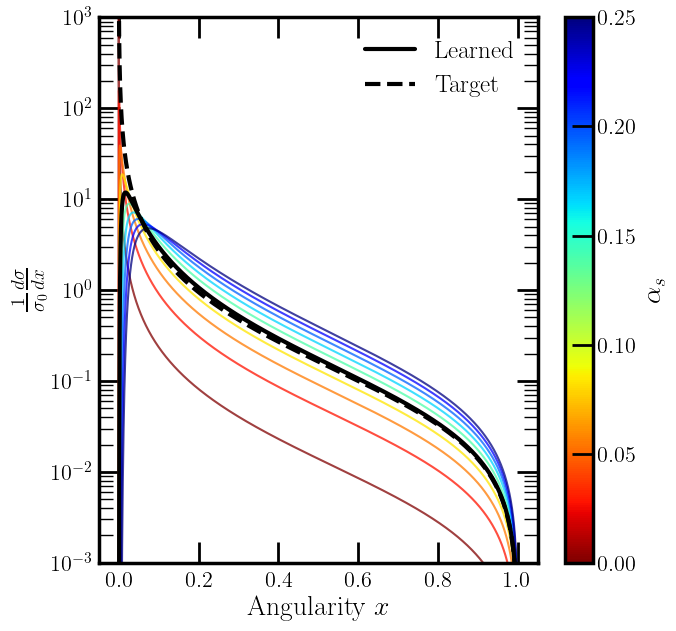

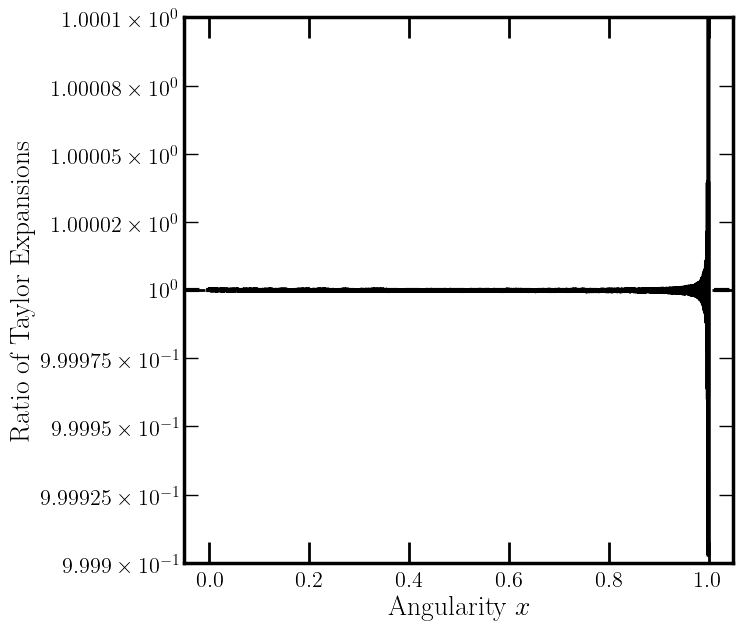

In [82]:
q = construct_pdf(polynomial_f)
vmapped_p = jax.vmap(p, in_axes=(0, 0))
vmapped_q = jax.vmap(q, in_axes=(0, 0, None))

taylor_q = taylor_expand_in_alpha(q, 1)
vmapped_taylor_q = jax.vmap(taylor_q, in_axes=(0, 0, None))



fig, ax = newplot("full")
x = jnp.linspace(0.0, 1, 10000)

cmap = plt.get_cmap("jet_r")
alphas = np.linspace(0.01, 0.25, 10)
colors = cmap(np.linspace(0, 1, len(alphas)))

for (i, alpha_choice) in enumerate(alphas):

    alpha = jnp.ones(10000) * alpha_choice
    plt.plot(x, vmapped_q(x, alpha, params), color = colors[i], lw = 1.5, alpha = 0.75)


# Colorbar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=0, vmax=0.25))
sm.set_array([])
plt.colorbar(sm, label = r"$\alpha_s$")

alpha = jnp.ones(10000) * 0.118
plt.plot(x, vmapped_q(x, alpha, params), color = "black", label = "Learned")
plt.plot(x, vmapped_p(x, alpha), color = "black", ls = "--", label = "Target")

plt.yscale("log")
plt.ylim(1e-3, 1e3)
plt.legend()
plt.ylabel(r"$\frac{1}{\sigma_0}\frac{d\sigma}{dx}$")
plt.xlabel(r"Angularity $x$")

# ##########################################################################

fig, ax = newplot("full")

for (i, alpha_choice) in enumerate(alphas):

    alpha = jnp.ones(10000) * alpha_choice
    plt.plot(x, vmapped_taylor_q(x, alpha, params) / vmapped_p(x, alpha), color = colors[i], lw = 1.5, alpha = 0.75)


alpha = jnp.ones(10000) * 0.118
plt.plot(x, vmapped_taylor_q(x, alpha, params) / vmapped_p(x, alpha), color = "black")
plt.axhline(1.0, color = "black", ls = "--")

plt.yscale('log')
plt.ylabel("Ratio of Taylor Expansions")
plt.xlabel(r"Angularity $x$")

plt.ylim(1 * 0.9999, 1 / 0.9999)


In [83]:
print(params)

# print out the f polynomial in t and alpha in a nice grid

print(r"$f(t|\alpha) = $")
M, N = params.shape
for i in range(M):
    s = ""
    for j in range(N):
        s += rf"{params[i,j]:.3f} $t^{i+1} \alpha^{j+1} + $  "

    print(s)



[[0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
  0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00]
 [1.0000001e+00 3.5681897e-01 8.4140748e-01 1.3150427e+00 1.6664217e+00
  1.8814822e+00 1.9990125e+00 2.0211692e+00 1.7246217e+00 6.5907627e-01]
 [8.1139397e-08 2.3775408e+00 0.0000000e+00 2.3303661e-02 1.8804289e-01
  3.7169743e-01 6.2213820e-01 7.0256168e-01 4.1630498e-01 2.8592732e-02]
 [0.0000000e+00 5.6612167e+00 2.1672258e+00 0.0000000e+00 0.0000000e+00
  0.0000000e+00 1.7946510e-02 7.1484880e-03 7.6234812e-01 2.0952785e-01]
 [0.0000000e+00 6.5212235e+00 6.8983798e+00 2.7024949e+00 0.0000000e+00
  0.0000000e+00 1.3448574e-01 7.7625953e-02 1.6579951e-01 8.3632189e-01]
 [0.0000000e+00 7.0597082e-02 1.1030123e+01 6.6893964e+00 1.9514956e+00
  5.4988086e-01 5.2645081e-01 9.7958535e-01 5.6441408e-01 2.4463387e-01]
 [0.0000000e+00 0.0000000e+00 9.1642542e+00 1.0130703e+01 3.1572800e+00
  1.1571809e+00 6.8563890e-01 4.4148231e-01 3.6789668e-01 

(0.001, 1000.0)

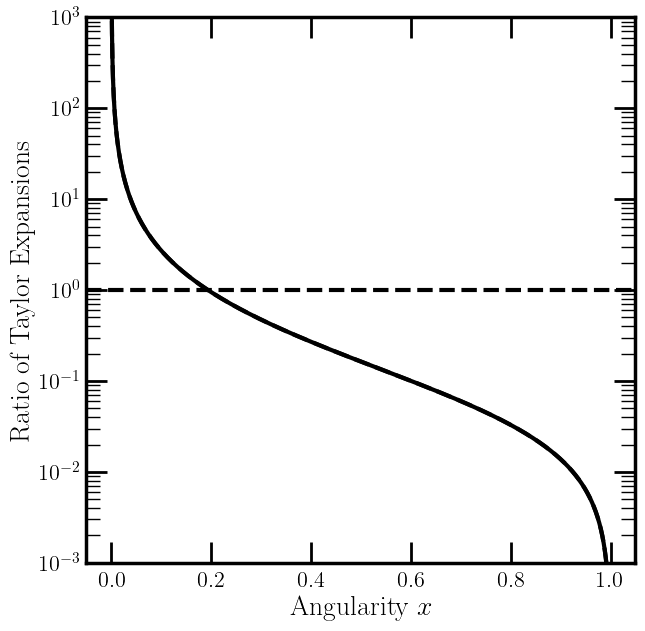

In [84]:
fig, ax = newplot("full")


alpha = jnp.ones(10000) * 0.118
plt.plot(x, vmapped_taylor_q(x, alpha, params), color = "black")
plt.plot(x, vmapped_p(x, alpha), color = "black", ls = "--")
plt.axhline(1.0, color = "black", ls = "--")

plt.yscale('log')
plt.ylabel("Ratio of Taylor Expansions")
plt.xlabel(r"Angularity $x$")

plt.ylim(1e-3, 1e3)